# Here is the same basic setup for a CNN pipeline but with with sparse data

In [2]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [3]:
tf.__version__



'2.3.0'

In [4]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

## code for viewing images from dataset

In [5]:
example = ds_train.take(5)
example

<TakeDataset shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)>

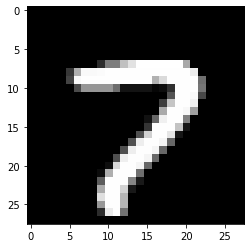

Label: 7


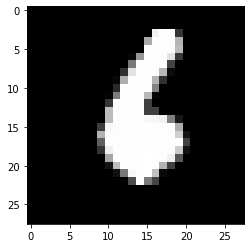

Label: 6


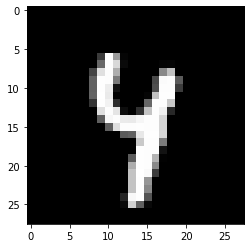

Label: 4


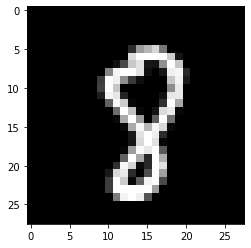

Label: 8


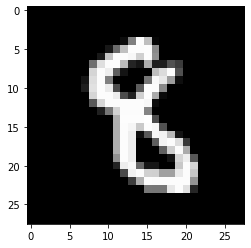

Label: 8


In [6]:
for sample in example:
    image, label = sample[0].numpy(), sample[1].numpy()
    plt.imshow(image[:, :, 0].astype(np.uint8), cmap=plt.get_cmap("gray"))
    plt.show()
    print("Label: %d" % label)

In [7]:
tf.random.uniform((6,8), maxval=2,dtype='int32')

<tf.Tensor: shape=(6, 8), dtype=int32, numpy=
array([[1, 0, 1, 1, 1, 1, 0, 1],
       [1, 0, 0, 1, 0, 0, 1, 1],
       [1, 1, 1, 0, 0, 1, 1, 1],
       [1, 1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 1, 0, 0, 1],
       [1, 1, 1, 0, 1, 1, 0, 1]])>

## code for making images sparse

In [8]:
def make_image_sparse(image, label, sparicty=.5):
    ones = np.ones(shape=image.shape)
    indices = np.random.choice(np.arange(ones.shape[0]*ones.shape[1]*ones.shape[2]), replace=False,
                           size=int(ones.shape[0]*ones.shape[1]*ones.shape[2] * sparicty))

    # sparse = tf.random.uniform(shape=image.shape, minval=0, maxval=2,dtype='int32')
    # sparse = tf.cast(sparse, tf.float32)
    ones[np.unravel_index(indices, ones.shape)] = 0
    sparse = tf.constant(ones, dtype=tf.float32)
    new_image = image * sparse
    return new_image, label
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label


In [9]:
ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.map(make_image_sparse, num_parallel_calls=tf.data.experimental.AUTOTUNE)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


# Test image manipulation

**Note:** I do not make the validation data sparse because it allows for better performance. This performance difference is likely due to having sparse training data but not sparse testing data has a similar effect on the model has having dropout layers.

In [10]:
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# ds_test = ds_test.map(make_image_sparse, num_parallel_calls=tf.data.experimental.AUTOTUNE)

## viewing sparse training data

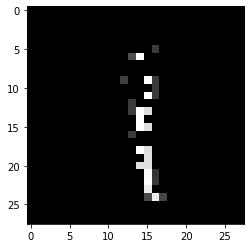

Label: 1


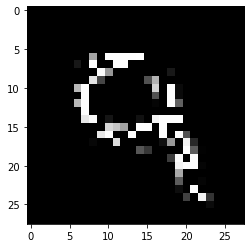

Label: 9


In [11]:
example_sparse = ds_train.take(2)
for sample in example_sparse:
    image, label = sample[0].numpy()*255, sample[1].numpy()
    plt.imshow(image[:, :, 0].astype(np.uint8), cmap=plt.get_cmap("gray"))
    plt.show()
    print("Label: %d" % label)

## viewing non-sparse test data

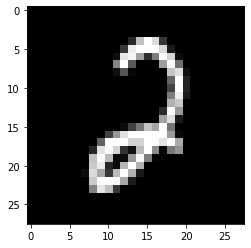

Label: 2


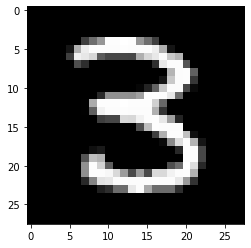

Label: 3


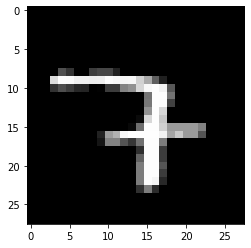

Label: 7


In [12]:
example_test = ds_test.take(3)
for sample in example_test:
    image, label = sample[0].numpy()*255, sample[1].numpy()
    plt.imshow(image[:, :, 0].astype(np.uint8), cmap=plt.get_cmap("gray"))
    plt.show()
    print("Label: %d" % label)

## regular steps follow

In [13]:

# ds_train = ds_train.map(
#     normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

In [14]:
# ds_test = ds_test.map(
#     normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

In [15]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(
    filters=10,
    kernel_size=3,
    input_shape=( 28, 28, 1),
    activation="relu"
    ),
  tf.keras.layers.Conv2D(10,3, activation='relu'),
  tf.keras.layers.MaxPool2D(),
  tf.keras.layers.Conv2D(10,3, activation='relu'),
  tf.keras.layers.Conv2D(10,3, activation='relu'),
  tf.keras.layers.MaxPool2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(10)
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

model.fit(
    ds_train,
    epochs=5,
    validation_data=ds_test,
)

Epoch 1/5
469/469 [==============================] - 13s 29ms/step - loss: 0.5739 - sparse_categorical_accuracy: 0.8105 - val_loss: 0.2720 - val_sparse_categorical_accuracy: 0.9162
Epoch 2/5
469/469 [==============================] - 13s 29ms/step - loss: 0.1978 - sparse_categorical_accuracy: 0.9390 - val_loss: 0.1787 - val_sparse_categorical_accuracy: 0.9454
Epoch 3/5
469/469 [==============================] - 13s 29ms/step - loss: 0.1520 - sparse_categorical_accuracy: 0.9529 - val_loss: 0.1438 - val_sparse_categorical_accuracy: 0.9540
Epoch 4/5
469/469 [==============================] - 13s 29ms/step - loss: 0.1275 - sparse_categorical_accuracy: 0.9601 - val_loss: 0.1369 - val_sparse_categorical_accuracy: 0.9577
Epoch 5/5
469/469 [==============================] - 13s 29ms/step - loss: 0.1125 - sparse_categorical_accuracy: 0.9649 - val_loss: 0.1306 - val_sparse_categorical_accuracy: 0.9580


In [16]:
model.evaluate(ds_test )

79/79 [==============================] - 1s 6ms/step - loss: 0.1306 - sparse_categorical_accuracy: 0.9580


[0.13064634799957275, 0.9580000042915344]

In [17]:
ds_test

<PrefetchDataset shapes: ((None, 28, 28, 1), (None,)), types: (tf.float32, tf.int64)>